# 1 导包和数据读取

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
#from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

In [2]:
#load_dataset
lanes_df = pd.read_csv('/kaggle/input/itsystem-data/Lane.csv')  
light_df = pd.read_csv('/kaggle/input/itsystem-data/Light_status.csv')
roads_df = pd.read_csv('/kaggle/input/itsystem-data/Entrance_road.csv') 
flow_df = pd.read_csv('/kaggle/input/itsystem-data/Flow.csv')

# 2 处理数据

## Lane.csv

In [3]:
lanes_df.head()

,LANE_ID,ARM_ID,LANE_NAME,DIR
0,1,E,左,L
1,1,N,左,L
2,1,S,左,L
3,1,W,左,L
4,2,E,直,S


In [4]:
lanes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LANE_ID    16 non-null     int64 
 1   ARM_ID     16 non-null     object
 2   LANE_NAME  16 non-null     object
 3   DIR        16 non-null     object
dtypes: int64(1), object(3)
memory usage: 640.0+ bytes


## Light_status.csv

In [5]:
light_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105844 entries, 0 to 105843
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   CYCLE_START_TIME  105844 non-null  object
 1   STAGE_START_TIME  105844 non-null  object
 2   STAGE_END_TIME    105844 non-null  object
 3   STAGE_LENGTH      105844 non-null  int64 
 4   GREEN_TIME        105844 non-null  int64 
 5   GREEN_FLASH_TIME  105844 non-null  int64 
 6   YELLOW_TIME       105844 non-null  int64 
 7   ALL_RED_TIME      105844 non-null  int64 
 8   CHANNELS          105844 non-null  object
 9   LANES             105844 non-null  object
 10  PHASES            105844 non-null  object
 11  LANE_FUNCS        105844 non-null  object
dtypes: int64(5), object(7)
memory usage: 9.7+ MB


In [6]:
# 转换成日期属性
light_df['CYCLE_START_TIME'] = pd.to_datetime(light_df['CYCLE_START_TIME'])
light_df['STAGE_START_TIME'] = pd.to_datetime(light_df['STAGE_START_TIME'])
light_df['STAGE_END_TIME'] = pd.to_datetime(light_df['STAGE_END_TIME'])

In [7]:
# 删除GREEN_FLASH_TIME YELLOW_TIME列
light_df.drop('GREEN_FLASH_TIME',axis=1,inplace=True)
light_df.drop('YELLOW_TIME',axis=1,inplace=True)

In [8]:
# 查找STAGE_LENGTH或GREEN_TIME小于0的行，并删除
neg_stage_length =light_df[(light_df['STAGE_LENGTH']<0)|(light_df['GREEN_TIME']<0)]
light_df = light_df.drop(neg_stage_length.index,axis=0)
light_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105759 entries, 0 to 105843
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   CYCLE_START_TIME  105759 non-null  datetime64[ns]
 1   STAGE_START_TIME  105759 non-null  datetime64[ns]
 2   STAGE_END_TIME    105759 non-null  datetime64[ns]
 3   STAGE_LENGTH      105759 non-null  int64         
 4   GREEN_TIME        105759 non-null  int64         
 5   ALL_RED_TIME      105759 non-null  int64         
 6   CHANNELS          105759 non-null  object        
 7   LANES             105759 non-null  object        
 8   PHASES            105759 non-null  object        
 9   LANE_FUNCS        105759 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(4)
memory usage: 8.9+ MB


In [9]:
# 处理LANES列
light_df['released_lanes'] = light_df['LANES'].str.split(',') # 用，分割

In [10]:
# 将放行车道号“_”前代表的进口道，1，2，3，4替换为为W，N，E，S。

# 定义一个替换函数 replace_dir
def replace_lanes(lanes):
    replaced = []
    for i in lanes:
        i = i.replace('1_', 'W_')
        i = i.replace('2_', 'N_')
        i = i.replace('3_', 'E_')
        i = i.replace('4_', 'S_')
        
        replaced.append(i)
    
    return replaced

# apply替换
light_df['released_lanes'] = light_df['released_lanes'].apply(replace_lanes)

In [11]:
light_df['released_lanes']

0         [W_2, W_3, E_2, W_4, E_3, E_4]
1         [W_2, W_3, E_2, W_4, E_3, E_4]
2         [W_2, W_3, E_2, W_4, E_3, E_4]
3         [W_2, W_3, E_2, W_4, E_3, E_4]
4         [W_2, W_3, E_2, W_4, E_3, E_4]
                       ...              
105839                        [N_1, S_1]
105840                        [N_1, S_1]
105841                        [N_1, S_1]
105842                        [N_1, S_1]
105843                        [N_1, S_1]
Name: released_lanes, Length: 105759, dtype: object

In [12]:
# 调换顺序，改为前面为车道号，后面为进口道，并去掉下划线
light_df['released_lanes'] = light_df['released_lanes'].apply(lambda lanes: [lane.replace('_', '')[-1] + lane.replace('_', '')[:-1] for lane in lanes])

In [13]:
light_df.head(40000)

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS,released_lanes
0,2023-08-01 00:01:08,2023-08-01 00:01:08,2023-08-01 00:01:30,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
1,2023-08-01 00:02:18,2023-08-01 00:02:18,2023-08-01 00:02:40,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2,2023-08-01 00:04:38,2023-08-01 00:04:38,2023-08-01 00:05:00,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
3,2023-08-01 00:05:48,2023-08-01 00:05:48,2023-08-01 00:06:10,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
4,2023-08-01 00:06:58,2023-08-01 00:06:58,2023-08-01 00:07:20,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
...,...,...,...,...,...,...,...,...,...,...,...
40030,2023-08-11 07:07:18,2023-08-11 07:08:02,2023-08-11 07:08:26,24,21,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
40031,2023-08-11 07:08:43,2023-08-11 07:09:27,2023-08-11 07:09:51,24,21,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
40032,2023-08-11 07:10:08,2023-08-11 07:10:52,2023-08-11 07:11:16,24,21,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
40033,2023-08-11 07:11:33,2023-08-11 07:12:17,2023-08-11 07:12:58,41,38,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"


In [14]:
# 按LANES分组
lanes_unique = light_df['LANES'].unique()
lanes_unique

array(['1_2,1_3,3_2,1_4,3_3,3_4', '1_1,3_1', '2_2,2_3,2_4,4_2,4_3,4_4',
       '2_1,4_1'], dtype=object)

In [15]:
# 按LANES分组
df_ligth_2W3W2E4W3E4E=light_df[light_df['LANES']=='1_2,1_3,3_2,1_4,3_3,3_4']
df_ligth_1W1E=light_df[light_df['LANES']=='1_1,3_1']
df_ligth_2N3N4N2S3S4S=light_df[light_df['LANES']=='2_2,2_3,2_4,4_2,4_3,4_4']
df_ligth_1N1S=light_df[light_df['LANES']=='2_1,4_1']

In [16]:
df_ligth_2W3W2E4W3E4E

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS,released_lanes
0,2023-08-01 00:01:08,2023-08-01 00:01:08,2023-08-01 00:01:30,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
1,2023-08-01 00:02:18,2023-08-01 00:02:18,2023-08-01 00:02:40,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2,2023-08-01 00:04:38,2023-08-01 00:04:38,2023-08-01 00:05:00,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
3,2023-08-01 00:05:48,2023-08-01 00:05:48,2023-08-01 00:06:10,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
4,2023-08-01 00:06:58,2023-08-01 00:06:58,2023-08-01 00:07:20,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
...,...,...,...,...,...,...,...,...,...,...,...
71245,2023-08-27 23:55:01,2023-08-27 23:55:01,2023-08-27 23:55:23,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
71246,2023-08-27 23:56:11,2023-08-27 23:56:11,2023-08-27 23:56:33,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
71247,2023-08-27 23:57:21,2023-08-27 23:57:21,2023-08-27 23:57:43,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
71248,2023-08-27 23:58:31,2023-08-27 23:58:31,2023-08-27 23:58:53,22,19,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"


In [17]:
# 删除STAGE_START_TIME，STAGE_END_TIME，LANES
df_ligth_2W3W2E4W3E4E.drop(['STAGE_START_TIME','STAGE_END_TIME','LANES'],axis=1,inplace=True)

In [18]:
#处理时间索引，按CYCLE_START_TIME为时间索引，从00:05:00开始，每五分钟为一个时间段

In [19]:
# 删除2023-08-01 00:05:00前的数据
df_ligth_2W3W2E4W3E4E=df_ligth_2W3W2E4W3E4E.drop(index=df_ligth_2W3W2E4W3E4E.index[:3])
df_ligth_2W3W2E4W3E4E=df_ligth_2W3W2E4W3E4E.reset_index(drop=True)
df_ligth_2W3W2E4W3E4E

,CYCLE_START_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
0,2023-08-01 00:05:48,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
1,2023-08-01 00:06:58,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2,2023-08-01 00:08:08,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
3,2023-08-01 00:09:18,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
4,2023-08-01 00:10:28,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
...,...,...,...,...,...,...,...,...
26447,2023-08-27 23:55:01,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
26448,2023-08-27 23:56:11,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
26449,2023-08-27 23:57:21,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
26450,2023-08-27 23:58:31,22,19,0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"


In [20]:
# 将第一个数据改成2023-08-01 00:05:00
#df_ligth_2W3W2E4W3E4E['CYCLE_START_TIME'][0]=pd.to_datetime("2023-08-01 00:05:00")
#df_ligth_2W3W2E4W3E4E.head()

In [21]:
# 将CYCLE_START_TIME设置为时间索引
df_ligth_2W3W2E4W3E4E=df_ligth_2W3W2E4W3E4E.set_index('CYCLE_START_TIME')
#df_ligth_2W3W2E4W3E4E.head(20)

In [22]:
# 对数据进行重新采样，以五分钟为一个时间段，并选择从00:05:00开始的数据：
start_time = pd.to_datetime("2023-08-01 00:05:00")
df_ligth_2W3W2E4W3E4E = df_ligth_2W3W2E4W3E4E.resample('5Min',label='left', closed='right').first().loc[start_time:] 

In [23]:
df_ligth_2W3W2E4W3E4E

,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
CYCLE_START_TIME,,,,,,,
2023-08-01 00:05:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:10:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:15:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:20:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:25:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
...,...,...,...,...,...,...,...
2023-08-27 23:35:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-27 23:40:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-27 23:45:00,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"


In [24]:
df_ligth_1W1E.head(10)

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS,released_lanes
14944,2023-07-31 23:59:58,2023-08-01 00:00:20,2023-08-01 00:00:33,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14945,2023-08-01 00:01:08,2023-08-01 00:01:30,2023-08-01 00:01:43,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14946,2023-08-01 00:02:18,2023-08-01 00:02:40,2023-08-01 00:02:53,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14947,2023-08-01 00:02:18,2023-08-01 00:03:50,2023-08-01 00:04:03,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14948,2023-08-01 00:04:38,2023-08-01 00:05:00,2023-08-01 00:05:13,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14949,2023-08-01 00:05:48,2023-08-01 00:06:10,2023-08-01 00:06:23,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14950,2023-08-01 00:06:58,2023-08-01 00:07:20,2023-08-01 00:07:33,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14951,2023-08-01 00:08:08,2023-08-01 00:08:30,2023-08-01 00:08:43,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14952,2023-08-01 00:09:18,2023-08-01 00:09:40,2023-08-01 00:09:53,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"
14953,2023-08-01 00:10:28,2023-08-01 00:10:50,2023-08-01 00:11:03,13,9,1,"1,9","1_1,3_1","4,9",12,"[1W, 1E]"


In [25]:
# 删除STAGE_START_TIME，STAGE_END_TIME，LANES
df_ligth_1W1E.drop(['STAGE_START_TIME','STAGE_END_TIME','LANES'],axis=1,inplace=True)

In [26]:
# 删除2023-08-01 00:05:00前的数据
df_ligth_1W1E = df_ligth_1W1E.drop(index=df_ligth_1W1E.index[:5])
df_ligth_1W1E=df_ligth_1W1E.reset_index(drop=True)
df_ligth_1W1E.head()

,CYCLE_START_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
0,2023-08-01 00:05:48,13,9,1,"1,9","4,9",12,"[1W, 1E]"
1,2023-08-01 00:06:58,13,9,1,"1,9","4,9",12,"[1W, 1E]"
2,2023-08-01 00:08:08,13,9,1,"1,9","4,9",12,"[1W, 1E]"
3,2023-08-01 00:09:18,13,9,1,"1,9","4,9",12,"[1W, 1E]"
4,2023-08-01 00:10:28,13,9,1,"1,9","4,9",12,"[1W, 1E]"


In [27]:
# 将第一条数据改成2023-08-01 00:05:00
#df_ligth_1W1E['CYCLE_START_TIME'][0]=pd.to_datetime('2023-08-01 00:05:00')

In [28]:
# 设置时间索引
df_ligth_1W1E=df_ligth_1W1E.set_index("CYCLE_START_TIME")
df_ligth_1W1E.head()

,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
CYCLE_START_TIME,,,,,,,
2023-08-01 00:05:48,13,9,1,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:06:58,13,9,1,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:08:08,13,9,1,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:09:18,13,9,1,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:10:28,13,9,1,"1,9","4,9",12,"[1W, 1E]"


In [29]:
# 对数据进行重新采样，以五分钟为一个时间段，并选择从00:05:00开始的数据：
df_ligth_1W1E = df_ligth_1W1E.resample('5Min',label='left',closed = 'right').first().loc[start_time:]

In [30]:
df_ligth_1W1E

,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
CYCLE_START_TIME,,,,,,,
2023-08-01 00:05:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:10:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:15:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:20:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:25:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
...,...,...,...,...,...,...,...
2023-08-27 23:35:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-27 23:40:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-27 23:45:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"


In [31]:
df_ligth_2N3N4N2S3S4S.head(10)

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS,released_lanes
29861,2023-07-31 23:59:58,2023-08-01 00:00:33,2023-08-01 00:00:55,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29862,2023-08-01 00:01:08,2023-08-01 00:01:43,2023-08-01 00:02:05,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29863,2023-08-01 00:02:18,2023-08-01 00:02:53,2023-08-01 00:03:15,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29864,2023-08-01 00:02:18,2023-08-01 00:04:03,2023-08-01 00:04:25,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29865,2023-08-01 00:04:38,2023-08-01 00:05:13,2023-08-01 00:05:35,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29866,2023-08-01 00:05:48,2023-08-01 00:06:23,2023-08-01 00:06:58,35,32,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29867,2023-08-01 00:06:58,2023-08-01 00:07:33,2023-08-01 00:07:55,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29868,2023-08-01 00:08:08,2023-08-01 00:08:43,2023-08-01 00:09:05,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29869,2023-08-01 00:09:18,2023-08-01 00:09:53,2023-08-01 00:10:15,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
29870,2023-08-01 00:10:28,2023-08-01 00:11:03,2023-08-01 00:11:25,22,19,0,"14,15,6,7","2_2,2_3,2_4,4_2,4_3,4_4","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"


In [32]:
# 删除STAGE_START_TIME，STAGE_END_TIME，LANES
df_ligth_2N3N4N2S3S4S.drop(['STAGE_START_TIME','STAGE_END_TIME','LANES'],axis=1,inplace=True)

In [33]:
# 删除数据 处理索引
df_ligth_2N3N4N2S3S4S = df_ligth_2N3N4N2S3S4S.drop(index=df_ligth_2N3N4N2S3S4S.index[:5])
df_ligth_2N3N4N2S3S4S = df_ligth_2N3N4N2S3S4S.reset_index(drop=True)

In [34]:
# 修改数据
#df_ligth_2N3N4N2S3S4S['CYCLE_START_TIME'][0]=pd.to_datetime('2023-08-01 00:05:00')

In [35]:
# 设置时间索引
df_ligth_2N3N4N2S3S4S=df_ligth_2N3N4N2S3S4S.set_index("CYCLE_START_TIME")

In [36]:
# 重新采样
df_ligth_2N3N4N2S3S4S=df_ligth_2N3N4N2S3S4S.resample('5Min',label='left',closed='right').first().loc[start_time:]

In [37]:
df_ligth_2N3N4N2S3S4S

,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
CYCLE_START_TIME,,,,,,,
2023-08-01 00:05:00,35.0,32.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-01 00:10:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-01 00:15:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-01 00:20:00,23.0,20.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-01 00:25:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
...,...,...,...,...,...,...,...
2023-08-27 23:35:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-27 23:40:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"
2023-08-27 23:45:00,22.0,19.0,0.0,"14,15,6,7","2,6,8","11,13","[2N, 3N, 4N, 2S, 3S, 4S]"


In [38]:
df_ligth_1N1S.head(10)

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS,released_lanes
44812,2023-07-31 23:59:58,2023-08-01 00:00:55,2023-08-01 00:01:08,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44813,2023-08-01 00:01:08,2023-08-01 00:02:05,2023-08-01 00:02:18,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44814,2023-08-01 00:02:18,2023-08-01 00:03:15,2023-08-01 00:03:50,35,31,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44815,2023-08-01 00:02:18,2023-08-01 00:04:25,2023-08-01 00:04:38,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44816,2023-08-01 00:04:38,2023-08-01 00:05:35,2023-08-01 00:05:48,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44817,2023-08-01 00:06:58,2023-08-01 00:07:55,2023-08-01 00:08:08,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44818,2023-08-01 00:08:08,2023-08-01 00:09:05,2023-08-01 00:09:18,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44819,2023-08-01 00:09:18,2023-08-01 00:10:15,2023-08-01 00:10:28,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44820,2023-08-01 00:10:28,2023-08-01 00:11:25,2023-08-01 00:11:38,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"
44821,2023-08-01 00:11:38,2023-08-01 00:12:35,2023-08-01 00:12:48,13,9,1,"13,5","2_1,4_1","1,7",12,"[1N, 1S]"


In [39]:
# 删除STAGE_START_TIME，STAGE_END_TIME，LANES
df_ligth_1N1S.drop(['STAGE_START_TIME','STAGE_END_TIME','LANES'],axis=1,inplace=True)

In [40]:
# 删除数据 整理索引
df_ligth_1N1S = df_ligth_1N1S.drop(index=df_ligth_1N1S.index[:4])
df_ligth_1N1S=df_ligth_1N1S.reset_index(drop=True)

In [41]:
# 修改数据
#df_ligth_1N1S['CYCLE_START_TIME'][0]=pd.to_datetime("2023-08-01 00:05:00")

In [42]:
# 设置时间索引
df_ligth_1N1S = df_ligth_1N1S.set_index("CYCLE_START_TIME")

In [43]:
# 重新采样
df_ligth_1N1S = df_ligth_1N1S.resample("5Min",label="left",closed="right").first().loc[start_time:]

In [44]:
df_ligth_1N1S

,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
CYCLE_START_TIME,,,,,,,
2023-08-01 00:05:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-01 00:10:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-01 00:15:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-01 00:20:00,12.0,8.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-01 00:25:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
...,...,...,...,...,...,...,...
2023-08-27 23:35:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-27 23:40:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"
2023-08-27 23:45:00,13.0,9.0,1.0,"13,5","1,7",12,"[1N, 1S]"


## Entrance_road.csv

In [45]:
roads_df.head()

,ARM_ID,ARM_NAME,DIR
0,E,东进口道,E
1,N,北进口道,N
2,S,南进口道,S
3,W,西进口道,W


## Flow.csv

In [46]:
flow_df

,LANE_ID,ARM_ID,START_TIME,END_TIME,VOLUMN_5MIN
0,1,E,2023-08-01 00:05:00,2023-08-01 00:10:00,2
1,1,E,2023-08-01 00:10:00,2023-08-01 00:15:00,1
2,1,E,2023-08-01 00:15:00,2023-08-01 00:20:00,0
3,1,E,2023-08-01 00:20:00,2023-08-01 00:25:00,1
4,1,E,2023-08-01 00:25:00,2023-08-01 00:30:00,0
...,...,...,...,...,...
120775,4,W,2023-08-27 23:35:00,2023-08-27 23:40:00,0
120776,4,W,2023-08-27 23:40:00,2023-08-27 23:45:00,0
120777,4,W,2023-08-27 23:45:00,2023-08-27 23:50:00,0
120778,4,W,2023-08-27 23:50:00,2023-08-27 23:55:00,0


In [47]:
flow_df['START_TIME'] = pd.to_datetime(flow_df['START_TIME'])
flow_df['END_TIME'] = pd.to_datetime(flow_df['END_TIME'])

In [48]:
flow_df['LANE_ARM']=flow_df['LANE_ID'].astype(str)+flow_df['ARM_ID']

In [49]:
lane_arm = flow_df.pop("LANE_ARM")
flow_df.insert(2,'LANE_ARM',lane_arm)

In [50]:
flow_df.drop(['LANE_ID','ARM_ID'],axis = 1,inplace = True)

In [51]:
flow_df

,LANE_ARM,START_TIME,END_TIME,VOLUMN_5MIN
0,1E,2023-08-01 00:05:00,2023-08-01 00:10:00,2
1,1E,2023-08-01 00:10:00,2023-08-01 00:15:00,1
2,1E,2023-08-01 00:15:00,2023-08-01 00:20:00,0
3,1E,2023-08-01 00:20:00,2023-08-01 00:25:00,1
4,1E,2023-08-01 00:25:00,2023-08-01 00:30:00,0
...,...,...,...,...
120775,4W,2023-08-27 23:35:00,2023-08-27 23:40:00,0
120776,4W,2023-08-27 23:40:00,2023-08-27 23:45:00,0
120777,4W,2023-08-27 23:45:00,2023-08-27 23:50:00,0
120778,4W,2023-08-27 23:50:00,2023-08-27 23:55:00,0


In [52]:
LANE_ARM_uniqe =flow_df['LANE_ARM'].unique()
LANE_ARM_uniqe

array(['1E', '1N', '1S', '1W', '2E', '2N', '2S', '2W', '3E', '3N', '3S',
       '3W', '4E', '4N', '4S', '4W'], dtype=object)

In [53]:
# 按LANE_ARM分组
df_flow_1E = flow_df[flow_df['LANE_ARM']=='1E']
df_flow_1N = flow_df[flow_df['LANE_ARM']=='1N']
df_flow_1S = flow_df[flow_df['LANE_ARM']=='1S']
df_flow_1W = flow_df[flow_df['LANE_ARM']=='1W']
df_flow_2E = flow_df[flow_df['LANE_ARM']=='2E']
df_flow_2N = flow_df[flow_df['LANE_ARM']=='2N']
df_flow_2S = flow_df[flow_df['LANE_ARM']=='2S']
df_flow_2W = flow_df[flow_df['LANE_ARM']=='2W']
df_flow_3E = flow_df[flow_df['LANE_ARM']=='3E']
df_flow_3N = flow_df[flow_df['LANE_ARM']=='3N']
df_flow_3S = flow_df[flow_df['LANE_ARM']=='3S']
df_flow_3W = flow_df[flow_df['LANE_ARM']=='3W']
df_flow_4E = flow_df[flow_df['LANE_ARM']=='4E']
df_flow_4N = flow_df[flow_df['LANE_ARM']=='4N']
df_flow_4S = flow_df[flow_df['LANE_ARM']=='4S']
df_flow_4W = flow_df[flow_df['LANE_ARM']=='4W']

In [54]:
flow_LANE_ARM = [df_flow_1E
,df_flow_1N
,df_flow_1S
,df_flow_1W
,df_flow_2E
,df_flow_2N
,df_flow_2S
,df_flow_2W
,df_flow_3E
,df_flow_3N
,df_flow_3S
,df_flow_3W
,df_flow_4E
,df_flow_4N
,df_flow_4S
,df_flow_4W]

In [55]:
for i in flow_LANE_ARM:
    print(i.shape)
    #i = i.reset_index(drop=True)


(7549, 4)
(7549, 4)
(7549, 4)
(7548, 4)
(7549, 4)
(7549, 4)
(7549, 4)
(7548, 4)
(7549, 4)
(7549, 4)
(7549, 4)
(7548, 4)
(7549, 4)
(7549, 4)
(7549, 4)
(7548, 4)


In [56]:
df_flow_1E = df_flow_1E.set_index('START_TIME')
df_flow_1N = df_flow_1N.set_index('START_TIME')
df_flow_1S = df_flow_1S.set_index('START_TIME')
df_flow_1W = df_flow_1W.set_index('START_TIME')
df_flow_2E = df_flow_2E.set_index('START_TIME')
df_flow_2N = df_flow_2N.set_index('START_TIME')
df_flow_2S = df_flow_2S.set_index('START_TIME')
df_flow_2W = df_flow_2W.set_index('START_TIME')
df_flow_3E = df_flow_3E.set_index('START_TIME')
df_flow_3N = df_flow_3N.set_index('START_TIME')
df_flow_3S = df_flow_3S.set_index('START_TIME')
df_flow_3W = df_flow_3W.set_index('START_TIME')
df_flow_4E = df_flow_4E.set_index('START_TIME')
df_flow_4N = df_flow_4N.set_index('START_TIME')
df_flow_4S = df_flow_4S.set_index('START_TIME')
df_flow_4W = df_flow_4W.set_index('START_TIME')

In [57]:
df_flow_4E

,LANE_ARM,END_TIME,VOLUMN_5MIN
START_TIME,,,
2023-08-01 00:05:00,4E,2023-08-01 00:10:00,0
2023-08-01 00:10:00,4E,2023-08-01 00:15:00,0
2023-08-01 00:15:00,4E,2023-08-01 00:20:00,0
2023-08-01 00:20:00,4E,2023-08-01 00:25:00,2
2023-08-01 00:25:00,4E,2023-08-01 00:30:00,0
...,...,...,...
2023-08-27 23:35:00,4E,2023-08-27 23:40:00,0
2023-08-27 23:40:00,4E,2023-08-27 23:45:00,0
2023-08-27 23:45:00,4E,2023-08-27 23:50:00,0


### 合并数据

#### 合并表格

In [58]:
#合并lanes_df和flow_df
#merged_df = pd.merge(lanes_df, flow_df, on=['LANE_ID', 'ARM_ID'])

In [59]:
# 合并
#merged_df_flow_4E = pd.merge(df_flow_4E,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='outer')
#merged_df_flow_4E

In [60]:
#df_ligth_1N1S
#df_ligth_2N3N4N2S3S4S
#df_ligth_1W1E
#df_ligth_2W3W2E4W3E4E

In [61]:
merged_df_flow_1E = pd.merge(df_flow_1E,df_ligth_1W1E, left_index=True, right_index=True, how='left')
merged_df_flow_1N = pd.merge(df_flow_1N,df_ligth_1N1S, left_index=True, right_index=True, how='left')
merged_df_flow_1S = pd.merge(df_flow_1S,df_ligth_1N1S, left_index=True, right_index=True, how='left')
merged_df_flow_1W = pd.merge(df_flow_1W,df_ligth_1W1E, left_index=True, right_index=True, how='left')
merged_df_flow_2E = pd.merge(df_flow_2E,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_df_flow_2N = pd.merge(df_flow_2N,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_2S = pd.merge(df_flow_2S,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_2W = pd.merge(df_flow_2W,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_df_flow_3E = pd.merge(df_flow_3E,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_df_flow_3N = pd.merge(df_flow_3N,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_3S = pd.merge(df_flow_3S,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_3W = pd.merge(df_flow_3W,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_df_flow_4E = pd.merge(df_flow_4E,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_df_flow_4N = pd.merge(df_flow_4N,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_4S = pd.merge(df_flow_4S,df_ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_df_flow_4W = pd.merge(df_flow_4W,df_ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')

In [62]:
merged_df_flow_2E

,LANE_ARM,END_TIME,VOLUMN_5MIN,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
START_TIME,,,,,,,,,,
2023-08-01 00:05:00,2E,2023-08-01 00:10:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:10:00,2E,2023-08-01 00:15:00,1,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:15:00,2E,2023-08-01 00:20:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:20:00,2E,2023-08-01 00:25:00,1,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-01 00:25:00,2E,2023-08-01 00:30:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
...,...,...,...,...,...,...,...,...,...,...
2023-08-27 23:35:00,2E,2023-08-27 23:40:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-27 23:40:00,2E,2023-08-27 23:45:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"
2023-08-27 23:45:00,2E,2023-08-27 23:50:00,0,22.0,19.0,0.0,"11,2,3,10","3,5,10","11,13","[2W, 3W, 2E, 4W, 3E, 4E]"


In [63]:
df_1E = merged_df_flow_1E.copy()
df_1N = merged_df_flow_1N.copy()
df_1S = merged_df_flow_1S.copy()
df_1W = merged_df_flow_1W.copy()
df_2E = merged_df_flow_2E.copy()
df_2N = merged_df_flow_2N.copy()
df_2S = merged_df_flow_2S.copy()
df_2W = merged_df_flow_2W.copy()
df_3E = merged_df_flow_3E.copy()
df_3N = merged_df_flow_3N.copy()
df_3S = merged_df_flow_3S.copy()
df_3W = merged_df_flow_3W.copy()
df_4E = merged_df_flow_4E.copy()
df_4N = merged_df_flow_4N.copy()
df_4S = merged_df_flow_4S.copy()
df_4W = merged_df_flow_4W.copy()

In [64]:
df_1E.drop(['LANE_ARM','END_TIME','CHANNELS','CHANNELS','LANE_FUNCS','PHASES','released_lanes'],axis = 1,inplace = True)

In [65]:
df_1E.head()

,VOLUMN_5MIN,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME
START_TIME,,,,
2023-08-01 00:05:00,2,13.0,9.0,1.0
2023-08-01 00:10:00,1,13.0,9.0,1.0
2023-08-01 00:15:00,0,13.0,9.0,1.0
2023-08-01 00:20:00,1,13.0,9.0,1.0
2023-08-01 00:25:00,0,13.0,9.0,1.0


# 2 单变量预测-PyTorch LSTM

In [173]:
# 合并车流量
LANE_ARM = [
df_flow_1N
,df_flow_1S
,df_flow_1W
,df_flow_2E
,df_flow_2N
,df_flow_2S
,df_flow_2W
,df_flow_3E
,df_flow_3N
,df_flow_3S
,df_flow_3W
,df_flow_4E
,df_flow_4N
,df_flow_4S
,df_flow_4W]

merged_flow = df_flow_1E['VOLUMN_5MIN']
merged_flow = pd.DataFrame(merged_flow)
for i in LANE_ARM:
    merged_flow['VOLUMN_5MIN'] = merged_flow['VOLUMN_5MIN']+i['VOLUMN_5MIN']
    
merged_flow

,VOLUMN_5MIN
START_TIME,
2023-08-01 00:05:00,7.0
2023-08-01 00:10:00,11.0
2023-08-01 00:15:00,6.0
2023-08-01 00:20:00,9.0
2023-08-01 00:25:00,2.0
...,...
2023-08-27 23:35:00,14.0
2023-08-27 23:40:00,6.0
2023-08-27 23:45:00,2.0


In [174]:
import torch
import torch.nn as nn

In [175]:
# 检查DataFrame中的空值
is_null = merged_flow['VOLUMN_5MIN'].isnull()
merged_flow[is_null]

,VOLUMN_5MIN
START_TIME,
2023-08-11 14:55:00,NaN


In [176]:
# 计算每列中的空值数量
null_count = is_null.sum()
print(null_count)

1


In [177]:
# 使用前一个非缺失值进行填充
merged_flow['VOLUMN_5MIN'].fillna(method='ffill', inplace=True)

In [268]:
data = merged_flow['VOLUMN_5MIN']
data = pd.DataFrame(data)
data.head()

,VOLUMN_5MIN
START_TIME,
2023-08-01 00:05:00,7.0
2023-08-01 00:10:00,11.0
2023-08-01 00:15:00,6.0
2023-08-01 00:20:00,9.0
2023-08-01 00:25:00,2.0


In [269]:
def get_val_loss(args, model, Val):
    model.eval()
    loss_function = nn.MSELoss().to(args.device)
    val_loss = []
    for (seq, label) in Val:
        with torch.no_grad():
            seq = seq.to(args.device)
            label = label.to(args.device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            val_loss.append(loss.item())

    return np.mean(val_loss)

In [270]:
def get_mape(x, y):
    """
    :param x:true
    :param y:pred
    :return:MAPE
    """
    return np.mean(np.abs((x - y) / x))

In [271]:
# 定义评价指标 SMAPE 函数
ep = 0.0000000001
def smape(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true) / (  ( np.abs(y_pred) + np.abs(y_true) ) / 2  ) + ep )

In [454]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)
    
    
def nn_seq_us(B,train_window):
    print('data processing...')
    dataset = data
    # split
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    #m, n = np.max(train[train.columns[0]]), np.min(train[train.columns[0]])
    


    def process(data, B, shuffle):
        load = data[data.columns[0]]
        load = load.tolist()
        data = data.values.tolist()
        #load = (load - n) / (m - n)
        seq = []
        for i in range(len(data) - train_window):
            train_seq = []
            train_label = []
            for j in range(i, i + train_window):
                x = [load[j]]
                train_seq.append(x)
            train_label.append(load[i + train_window])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=B, shuffle=shuffle, num_workers=0, drop_last=True)

        return seq

    Dtr = process(train, B, True)
    Val = process(val, B, True)
    Dte = process(test, B, False)

    #return Dtr, Val, Dte, m, n
    return Dtr, Val, Dte
# Dtr为训练集，Val为验证集，Dte为测试集。

In [455]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        #h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        #c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        # Initialize hidden and cell state
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) 
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0, c_0)) 
        pred = self.linear(output)  
        pred = pred[:, -1, :]
        return pred



In [493]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def train(args, Dtr, Val, path):
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)

    loss_function = nn.MSELoss().to(device)
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr,
                                     weight_decay=args.weight_decay)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr,
                                    momentum=0.9, weight_decay=args.weight_decay)
    scheduler = StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
    # training
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in tqdm(range(args.epochs)):
        train_loss = []
        for (seq, label) in Dtr:
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        # validation
        val_loss = get_val_loss(args, model, Val)
        if epoch > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)
        if best_model is None:
            print("No best model found, saving final model")
            best_model = model
        if epoch % 10 == 1:
            print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
                
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)
    return model


In [494]:
from itertools import chain
from scipy.interpolate import make_interp_spline
#def test(args, Dte, path, m, n):
def test(args, Dte, path):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    # models = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    model.load_state_dict(torch.load(path)['models'])

    model.eval()
    print('predicting...')
    for (seq, target) in tqdm(Dte):
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    #y = (m - n) * y + n
    #pred = (m - n) * pred + n
    
    #pred = np.round(pred)  # 将数组中的值四舍五入为最接近的整数
    print(pred)
    
    #print('mape:', get_mape(y, pred))
    print('smape:', smape(pred,y))
    # plot
    x = [i for i in range(1, 151)]
    x_smooth = np.linspace(np.min(x), np.max(x), 900)
    y_smooth = make_interp_spline(x, y[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    y_smooth = make_interp_spline(x, pred[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    plt.show()


In [495]:
class Args:
    def __init__(self):
        self.input_size = 1  # 输入大小
        self.batch_size = 20  # 批次大小
        self.hidden_size = 128  # 隐藏层大小
        self.num_layers = 1  # LSTM层数
        self.output_size = 1  # 输出大小
        self.bidirectional = False  # 是否使用双向LSTM
        self.lr = 0.001  # 学习率
        self.weight_decay = 0.0001  # 权重衰减
        self.optimizer = 'adam'  # 优化器选择（'adam'或'sgd'）
        self.step_size = 8  # 调整学习率的步长
        self.gamma = 0.1  # 学习率调整因子
        self.epochs = 100  # 训练轮数
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 实例化Args对象
args = Args()
train_window=288
#Dtr, Val, Dte, m, n = nn_seq_us(20,train_window)
Dtr, Val, Dte = nn_seq_us(20,train_window)
print('df_train---',len(Dtr))
print('df_val---',len(Val))
print('df_test---',len(Dte))

data processing...
df_train--- 212
df_val--- 61
df_test--- 61


In [496]:
model = train(args, Dtr, Val, path='/kaggle/working/model101.txt')


  1%|          | 1/100 [00:01<01:48,  1.10s/it]

No best model found, saving final model


  2%|▏         | 2/100 [00:02<01:46,  1.09s/it]

epoch 001 train_loss 954.83771565 val_loss 711.20081317


 12%|█▏        | 12/100 [00:13<01:35,  1.09s/it]

epoch 011 train_loss 161.57126903 val_loss 163.76173198


 22%|██▏       | 22/100 [00:24<01:27,  1.13s/it]

epoch 021 train_loss 151.53221159 val_loss 154.78490817


 32%|███▏      | 32/100 [00:35<01:14,  1.09s/it]

epoch 031 train_loss 150.71288480 val_loss 153.72307318


 42%|████▏     | 42/100 [00:46<01:03,  1.09s/it]

epoch 041 train_loss 150.65217714 val_loss 153.80710727


 52%|█████▏    | 52/100 [00:57<00:53,  1.12s/it]

epoch 051 train_loss 150.64203284 val_loss 154.11243170


 62%|██████▏   | 62/100 [01:08<00:41,  1.09s/it]

epoch 061 train_loss 150.66541863 val_loss 153.47822452


 72%|███████▏  | 72/100 [01:19<00:30,  1.10s/it]

epoch 071 train_loss 150.66218128 val_loss 153.56967172


 82%|████████▏ | 82/100 [01:30<00:20,  1.12s/it]

epoch 081 train_loss 150.66434457 val_loss 154.00794395


 92%|█████████▏| 92/100 [01:41<00:08,  1.10s/it]

epoch 091 train_loss 150.63234062 val_loss 151.43536189


100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


loading models...
predicting...


100%|██████████| 61/61 [00:00<00:00, 484.74it/s]


[91.69101715 91.69258118 90.67822266 ... 10.60492134 10.60668087
 10.00434208]
smape: 0.2797563251140618


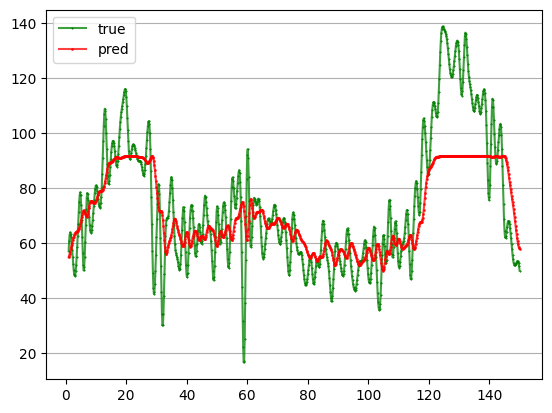

In [497]:
#test(args,Dte,path='/kaggle/working/model101.txt',m=m,n=n)
test(args,Dte,path='/kaggle/working/model101.txt')

In [498]:
# 预测28日的车流量
# 设定预测时间步数
fut_pred = 288


In [499]:
from itertools import chain
from scipy.interpolate import make_interp_spline
#def predict(args, pre_inputs, fut_pred, m, n,path):
def predict(args, pre_inputs, fut_pred,path):
    pred = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    model.load_state_dict(torch.load(path)['models'])
    #model.eval()
    load = pre_inputs[pre_inputs.columns[0]]
    load = load.tolist()
    load = (load - n) / (m - n)
    for i in range(fut_pred):
        seq = []
        for i in range(len(load) - train_window, len(load)):
            seq.append([load[i]])
        seq = [seq]
        seq = torch.FloatTensor(seq)
        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=1, shuffle=False, num_workers=0)
       # print(new_seq)
        seq = [x for x in iter(seq)][0]
        #print(seq.shape)  # (1, 24, 1) batch_size=1, seq_len=24, input_size=1
        # 开始预测
        seq = seq.to(device)
        with torch.no_grad():
            #y_pred = model(seq) 
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))

        load = np.append(load, y_pred)
        pred.extend(y_pred)
    # 将 y_pred 转换为 Numpy 数组
    # y_pred = np.array(y_pred)
    pred = np.array(pred)
    pred = pred * (m - n) + n
    pred = np.round(pred)  # 将数组中的值四舍五入为最接近的整数
    # plot
    x = range(len(pred))
    plt.plot(x, pred)
    #plt.plot(x, pred, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.show()
    
    return pred

In [500]:
from itertools import chain
from scipy.interpolate import make_interp_spline
#def predict2(model, pre_inputs, fut_pred, m, n):
def predict2(model, pre_inputs, fut_pred):
    pred = []
    model.eval()
    
    load = pre_inputs[pre_inputs.columns[0]]
    load = load.tolist()
    #load = (load - n) / (m - n)
    for i in range(fut_pred):
        seq = []
        for i in range(len(load) - train_window, len(load)):
            seq.append([load[i]])
        seq = [seq]
        seq = torch.FloatTensor(seq)
        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=1, shuffle=False, num_workers=0)
       # print(new_seq)
        seq = [x for x in iter(seq)][0]
        #print(seq.shape)  # (1, 24, 1) batch_size=1, seq_len=24, input_size=1
        # 开始预测
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
        load = np.append(load, y_pred)
        pred.extend(y_pred)
    # 将 y_pred 转换为 Numpy 数组
    # y_pred = np.array(y_pred)
    pred = np.array(pred)
    #pred = pred * (m - n) + n
    #pred = np.round(pred)  # 将数组中的值四舍五入为最接近的整数
    # plot
    x = range(len(pred))
    plt.plot(x, pred)
    #plt.plot(x, pred, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.show()
    
    return pred

loading models...


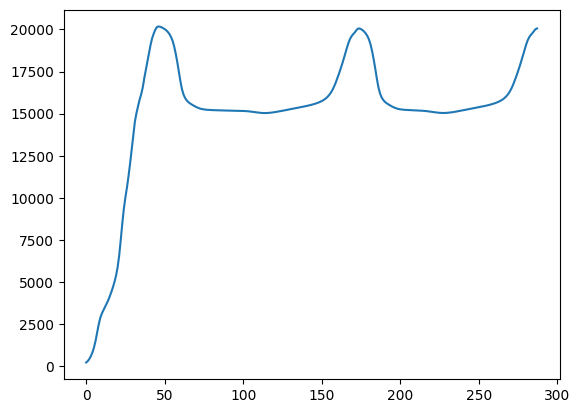

In [501]:
#pred = predict(args=args, pre_inputs=data, fut_pred=fut_pred, m=m, n=n,path='/kaggle/working/model100.txt')
pred = predict(args=args, pre_inputs=data, fut_pred=fut_pred,path='/kaggle/working/model101.txt')

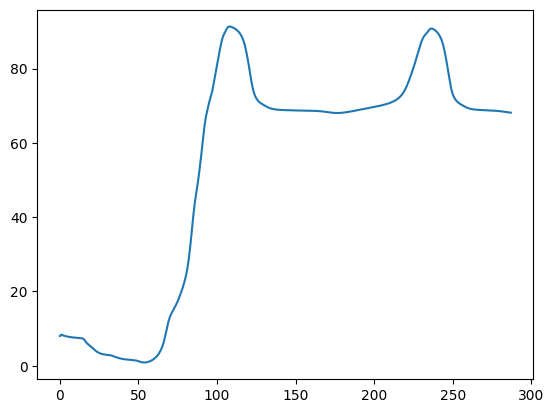

In [503]:
#pre = predict2(model=model, pre_inputs=data, fut_pred=fut_pred, m=m, n=n)
pre = predict2(model=model, pre_inputs=data, fut_pred=fut_pred)

# 4 多变量预测

In [94]:
import torch
import torch.nn as nn

In [67]:
df= merged_df_flow_1E.copy()
df.drop(['LANE_ARM','END_TIME','CHANNELS','CHANNELS','LANE_FUNCS','PHASES','released_lanes'],axis = 1,inplace = True)

In [68]:
df.head()

,VOLUMN_5MIN,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME
START_TIME,,,,
2023-08-01 00:05:00,2,13.0,9.0,1.0
2023-08-01 00:10:00,1,13.0,9.0,1.0
2023-08-01 00:15:00,0,13.0,9.0,1.0
2023-08-01 00:20:00,1,13.0,9.0,1.0
2023-08-01 00:25:00,0,13.0,9.0,1.0


In [69]:
# 检查DataFrame中的空值
is_null = df.isnull()
# 计算每列中的空值数量
null_count = is_null.sum()
print(null_count)
print(df[is_null])

VOLUMN_5MIN       0
STAGE_LENGTH    320
GREEN_TIME      320
ALL_RED_TIME    320
dtype: int64
                     VOLUMN_5MIN  STAGE_LENGTH  GREEN_TIME  ALL_RED_TIME
START_TIME                                                              
2023-08-01 00:05:00          NaN           NaN         NaN           NaN
2023-08-01 00:10:00          NaN           NaN         NaN           NaN
2023-08-01 00:15:00          NaN           NaN         NaN           NaN
2023-08-01 00:20:00          NaN           NaN         NaN           NaN
2023-08-01 00:25:00          NaN           NaN         NaN           NaN
...                          ...           ...         ...           ...
2023-08-27 23:35:00          NaN           NaN         NaN           NaN
2023-08-27 23:40:00          NaN           NaN         NaN           NaN
2023-08-27 23:45:00          NaN           NaN         NaN           NaN
2023-08-27 23:50:00          NaN           NaN         NaN           NaN
2023-08-27 23:55:00          Na

In [70]:
# 使用前一个非缺失值进行填充
df['VOLUMN_5MIN'].fillna(method='ffill', inplace=True)
df['STAGE_LENGTH'].fillna(method='ffill', inplace=True)
df['GREEN_TIME'].fillna(method='ffill', inplace=True)
df['ALL_RED_TIME'].fillna(method='ffill', inplace=True)

In [71]:
# 首先对除目标列其他变量进行归一化
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
columns_to_normalize = ['STAGE_LENGTH', 'GREEN_TIME', 'ALL_RED_TIME']
data_to_normalize = df[columns_to_normalize].to_numpy()
normalized_data = scaler.fit_transform(data_to_normalize)
df[columns_to_normalize] = normalized_data

In [72]:
df.describe()

,VOLUMN_5MIN,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME
count,7549.000000,7549.000000,7549.000000,7549.0
mean,6.619552,-0.847315,-0.847315,-1.0
std,6.758450,0.087934,0.087934,0.0
min,0.000000,-1.000000,-1.000000,-1.0
25%,1.000000,-0.909091,-0.909091,-1.0
50%,5.000000,-0.848485,-0.848485,-1.0
75%,10.000000,-0.818182,-0.818182,-1.0
max,74.000000,1.000000,1.000000,-1.0


In [207]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

    
    
def nn_seq_us2(B):
    print('data processing...')
    dataset = df
    # split
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    m, n = np.max(train[train.columns[0]]), np.min(train[train.columns[0]])
    


    def process(data, B, shuffle):
        load = data[data.columns[0]] # load：目标变量 0：目标列
        load = load.tolist()
        data = data.values.tolist() # data所有数据
        load = (load - n) / (m - n)
        seq = []
        for i in range(len(data) - 100):
            train_seq = []
            train_label = []
            for j in range(i, i + 100):
                x = [load[j]]
                #train_seq.append(x)
                for c in range(1, 4): # （1,4）其他变量列
                    #train_seq.append(data[i + 24][c])
                    x.append(data[j][c])
                train_seq.append(x)
            train_label.append(load[i + 100])
            
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        #print('seq.shape---',seq.shape)
        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=B, shuffle=shuffle, num_workers=0, drop_last=True)

        return seq

    Dtr = process(train, B, True)
    Val = process(val, B, True)
    Dte = process(test, B, False)

    return Dtr, Val, Dte, m, n
# Dtr为训练集，Val为验证集，Dte为测试集。

In [304]:
class Args:
    def __init__(self):
        self.input_size = 4  # 输入大小
        self.batch_size = 20  # 批次大小
        self.hidden_size = 128  # 隐藏层大小
        self.num_layers = 4  # LSTM层数
        self.output_size = 1  # 输出大小
        self.bidirectional = False  # 是否使用双向LSTM
        self.lr = 0.001  # 学习率
        self.weight_decay = 0.0001  # 权重衰减
        self.optimizer = 'adam'  # 优化器选择（'adam'或'sgd'）
        self.step_size = 8  # 调整学习率的步长
        self.gamma = 0.1  # 学习率调整因子
        self.epochs = 100  # 训练轮数
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 实例化Args对象
args = Args()
Dtr, Val, Dte, m, n = nn_seq_us2(20)

data processing...


In [305]:
train(args, Dtr, Val, path='/kaggle/working/model10.txt')

  2%|▏         | 2/100 [00:03<02:38,  1.62s/it]

epoch 001 train_loss 0.00566679 val_loss 0.00493625


 12%|█▏        | 12/100 [00:19<02:21,  1.61s/it]

epoch 011 train_loss 0.00487466 val_loss 0.00439303


 22%|██▏       | 22/100 [00:35<02:05,  1.61s/it]

epoch 021 train_loss 0.00483106 val_loss 0.00426442


 32%|███▏      | 32/100 [00:51<01:49,  1.62s/it]

epoch 031 train_loss 0.00481372 val_loss 0.00422979


 42%|████▏     | 42/100 [01:08<01:33,  1.62s/it]

epoch 041 train_loss 0.00482313 val_loss 0.00422129


 52%|█████▏    | 52/100 [01:24<01:17,  1.61s/it]

epoch 051 train_loss 0.00481651 val_loss 0.00426721


 62%|██████▏   | 62/100 [01:40<01:01,  1.62s/it]

epoch 061 train_loss 0.00482396 val_loss 0.00428266


 72%|███████▏  | 72/100 [01:56<00:45,  1.61s/it]

epoch 071 train_loss 0.00481745 val_loss 0.00425603


 82%|████████▏ | 82/100 [02:12<00:29,  1.62s/it]

epoch 081 train_loss 0.00482087 val_loss 0.00428531


 92%|█████████▏| 92/100 [02:28<00:12,  1.61s/it]

epoch 091 train_loss 0.00481281 val_loss 0.00426730


100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


LSTM(
  (lstm): LSTM(4, 128, num_layers=4, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

loading models...
predicting...


100%|██████████| 70/70 [00:00<00:00, 342.38it/s]


smape: 0.8035178421118762


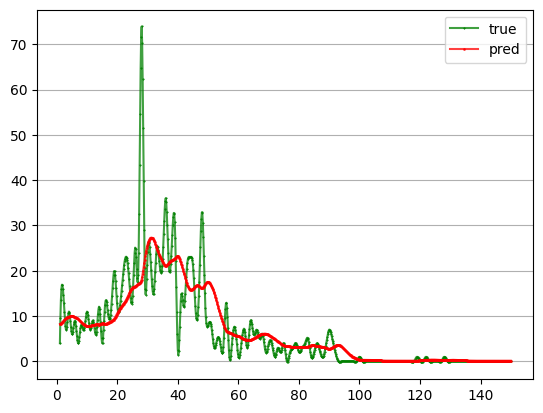

In [306]:
test(args,Dte,path='/kaggle/working/model10.txt',m=m,n=n)